In [1]:
# import numpy as np
# import pandas as pd

# file_path = '附件一（训练集）.xlsx'
# data_list = []
# for sheet_name in ['材料1', '材料2', '材料3', '材料4']:
#     df = pd.read_excel(file_path, sheet_name=sheet_name)
#     df['material'] = sheet_name
#     data_list.append(df)
# df = pd.concat(data_list, ignore_index=True)

In [2]:
from feature import *
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F

def extract_features(row):
    flux_density = row.iloc[4:-1]  # 假设磁通密度列从第5列开始
    # print(type(flux_arr))
    flux_arr = flux_density.values.astype(float)
    print(len(flux_arr))
    fs = float( row.iloc[1] )
    print(f"fs{fs} type {type(fs)}")
    skewness, symmetric_messure = calculate_symmetry(flux_arr)
    max_freq, mean_mag, std_mag, energy = extract_frequency_features(flux_arr, fs)
    rise_time, fall_time = calculate_rise_and_fall(flux_arr)
    increase_points, decrease_points = calculate_sudden(flux_arr)
    slope = calculate_slope(flux_arr)
    return pd.Series({
        'mean_flux': np.mean(flux_arr),
        'std_flux': np.std(flux_arr),
        'max_flux': np.max(flux_arr),
        'min_flux': np.min(flux_arr),
        'range_flux': np.max(flux_arr) - np.min(flux_arr),
        'skewness': skewness,
        'symmetric_messure': symmetric_messure,
        'max_freq': max_freq,
        'mean_mag': mean_mag,
        'std_mag': std_mag,
        'energy': energy,
        'slope_mean': np.mean(slope),
        'slope_std': np.std(slope),
        'slope_max': np.max(slope),
        'slope_min': np.min(slope),
        'slope_abs_mean': np.mean(np.abs(slope)),
        'duty_cicle': calculate_duty_cycle(flux_arr),
        'rise_time': rise_time,
        'fall_time': fall_time,
        'increase_points':increase_points,
        'decrease_points':decrease_points,
    })

# features = merged_data.apply(extract_features, axis=1)

In [3]:
df = pd.read_csv('all_train_full_loss.csv')
df[:2]

,temperature,frequency,core_loss,waveform,0,1,2,3,4,5,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,material
0,25,50030,1997.95525,正弦波,0.000213,0.000389,0.000566,0.000743,0.000919,0.001096,...,-0.001374,-0.001198,-0.001022,-0.000846,-0.000669,-0.000492,-0.000316,-0.000140,0.000036,材料1
1,25,50020,2427.74983,正弦波,-0.000551,-0.000358,-0.000165,0.000028,0.000221,0.000413,...,-0.002284,-0.002091,-0.001899,-0.001707,-0.001515,-0.001322,-0.001129,-0.000937,-0.000744,材料1


In [5]:
signal = df.iloc[0,4:-1].values
signal
fs = df.iloc[0,1].astype(float)
fs
extract_frequency_features(signal, fs)

(np.float64(48.857421875),
 np.float64(0.028984011780686356),
 np.float64(0.6521623141714985),
 np.float64(218.19174756578678))

In [15]:
signal[-1]

np.float64(3.63e-05)

In [ ]:
df_train_feature = df.apply(extract_features, axis=1)
df_train_feature[:2]

In [11]:
max_freq = df_train_feature['max_freq'].values
len(set(max_freq.tolist()))

160

In [72]:
# df.to_csv('all_train.csv', index=False, encoding='utf-8-sig')

In [1]:
# import pandas as pd
# df = pd.read_csv('all_train.csv')
# # df.iloc[:, 2] = df.iloc[:, 2].round()

In [2]:
df[:2]

,temperature,frequency,core_loss,waveform,0,1,2,3,4,5,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,material
0,25,50030,1998.0,正弦波,0.000213,0.000389,0.000566,0.000743,0.000919,0.001096,...,-0.001374,-0.001198,-0.001022,-0.000846,-0.000669,-0.000492,-0.000316,-0.000140,0.000036,材料1
1,25,50020,2428.0,正弦波,-0.000551,-0.000358,-0.000165,0.000028,0.000221,0.000413,...,-0.002284,-0.002091,-0.001899,-0.001707,-0.001515,-0.001322,-0.001129,-0.000937,-0.000744,材料1


In [10]:
# Extract features
material_label_encoder = LabelEncoder()
waveform_label_encoder = LabelEncoder()

material = material_label_encoder.fit_transform( df['material'].values)
temperature = df['温度，oC'].values
frequency = df['频率，Hz'].values
wave_label = waveform_label_encoder.fit_transform( df['励磁波形'].values )
# flux_density = df.iloc[:, 4:-1].values  # From the 5th column to the last column
core_loss = df['磁芯损耗，w/m3'].values


In [15]:
df_train_feature['material'] = material
df_train_feature['temperature'] = temperature
df_train_feature['frequency'] = frequency
df_train_feature['wave_label'] = wave_label
df_train_feature['core_loss'] = core_loss
df_train_feature[:2]

,mean_flux,std_flux,max_flux,min_flux,range_flux,skewness,symmetric_messure,max_freq,mean_mag,std_mag,...,duty_cicle,rise_time,fall_time,increase_points,decrease_points,material,temperature,frequency,wave_label,core_loss
0,-4.003906e-11,0.020400,0.028849,-0.028840,0.057689,-0.000627,0.036719,48.857422,0.028984,0.652162,...,50.000000,16.0,-75.0,0.0,0.0,0,25,50030,2,1997.95525
1,-2.539063e-11,0.022223,0.031419,-0.031427,0.062846,-0.001222,0.039992,48.847656,0.031583,0.710445,...,50.097656,20.0,-75.0,0.0,0.0,0,25,50020,2,2427.74983


In [17]:
# df_train_feature.to_csv("features25_and_full_loss.csv", encoding='utf-8', index=False)

In [30]:
# 导入必要的库 随机森林代码
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 假设你已经加载了数据集，X是你的特征，y是目标变量
# 数据加载和划分 (这里假设你的目标变量在最后一列)
df = pd.read_csv('feature25_with_loss_new.csv')

# 特征和目标
X = df.iloc[:, :-1]  # 所有列，除了最后一列
y = df.iloc[:, -1]   # 最后一列是目标磁芯损失值

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 初始化随机森林回归模型
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# 训练模型
rf_model.fit(X_train, y_train)

# 预测
y_pred = rf_model.predict(X_test)

# 评估模型性能
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"均方误差 (MSE): {mse}")
print(f"决定系数 (R^2): {r2}")

均方误差 (MSE): 2164068125.3398833
决定系数 (R^2): 0.983914884382032


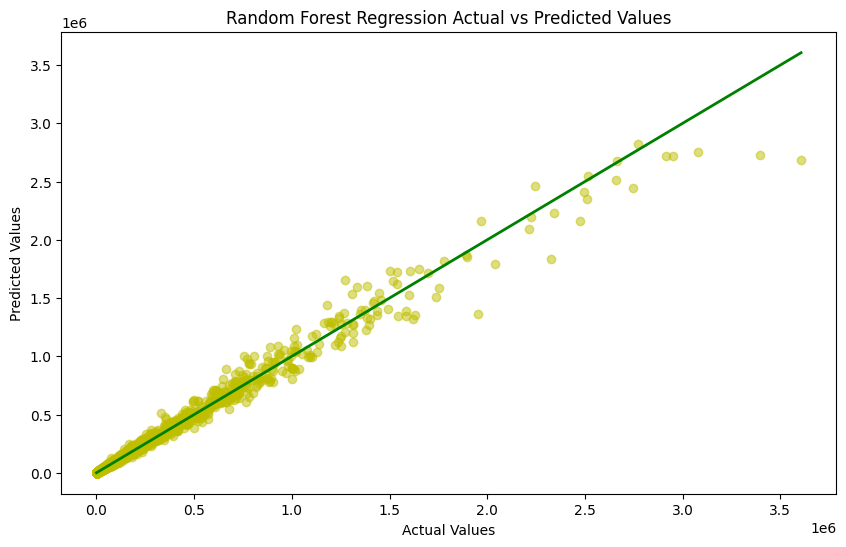

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, c='y')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'g', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Random Forest Regression Actual vs Predicted Values')
plt.show()

In [32]:
#XGB代码
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 假设你已经加载了数据集，X是你的特征，y是目标变量
# 数据加载和划分 (这里假设你的目标变量在最后一列)
df = pd.read_csv('feature_and_loss.csv')

# 特征和目标
X = df.iloc[:, :-1]  # 所有列，除了最后一列
y = df.iloc[:, -1]   # 最后一列是目标磁芯损失值

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 将数据转换为DMatrix格式，适用于XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 设置模型参数
params = {
    'objective': 'reg:squarederror',  # 目标函数是平方误差（回归任务）
    'eval_metric': 'rmse',  # 评估标准是均方根误差（RMSE）
    'learning_rate': 0.1,  # 学习率
    'max_depth': 6,  # 树的最大深度
    'n_estimators': 100,  # 树的数量
    'random_state': 42
}

# 训练模型
xg_model = xgb.train(params, dtrain, num_boost_round=100)

# 预测
y_pred = xg_model.predict(dtest)

# 评估模型性能
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"均方误差 (MSE): {mse}")
print(f"决定系数 (R^2): {r2}")

均方误差 (MSE): 1077278567.8921232
决定系数 (R^2): 0.9919927888349609


/home/dell/miniconda3/envs/agent/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [13:16:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


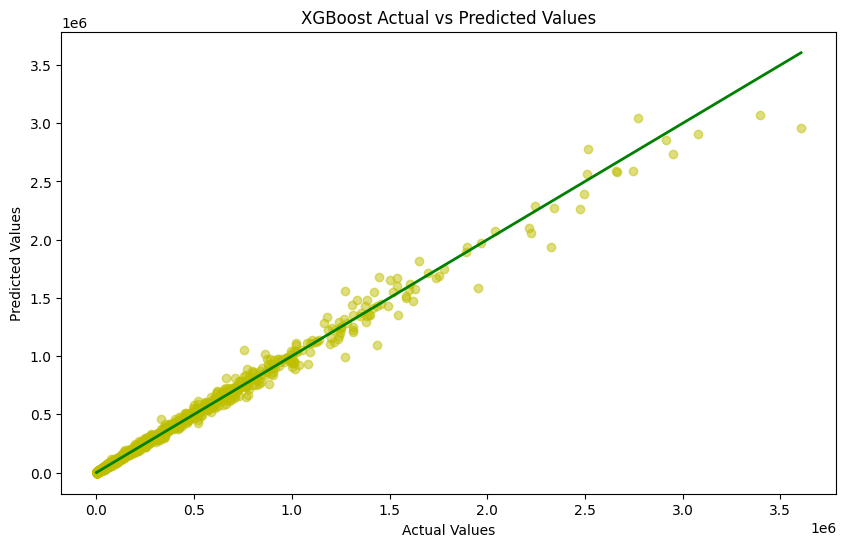

In [33]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, c='y')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'g', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('XGBoost Actual vs Predicted Values')
plt.show()

In [3]:
df = pd.read_csv('feature25_with_loss_new.csv')


In [23]:
min(df['core_loss']), max(df['core_loss']), np.mean(df['core_loss'])

(415.6131139, 3616132.536, np.float64(198978.28830621453))

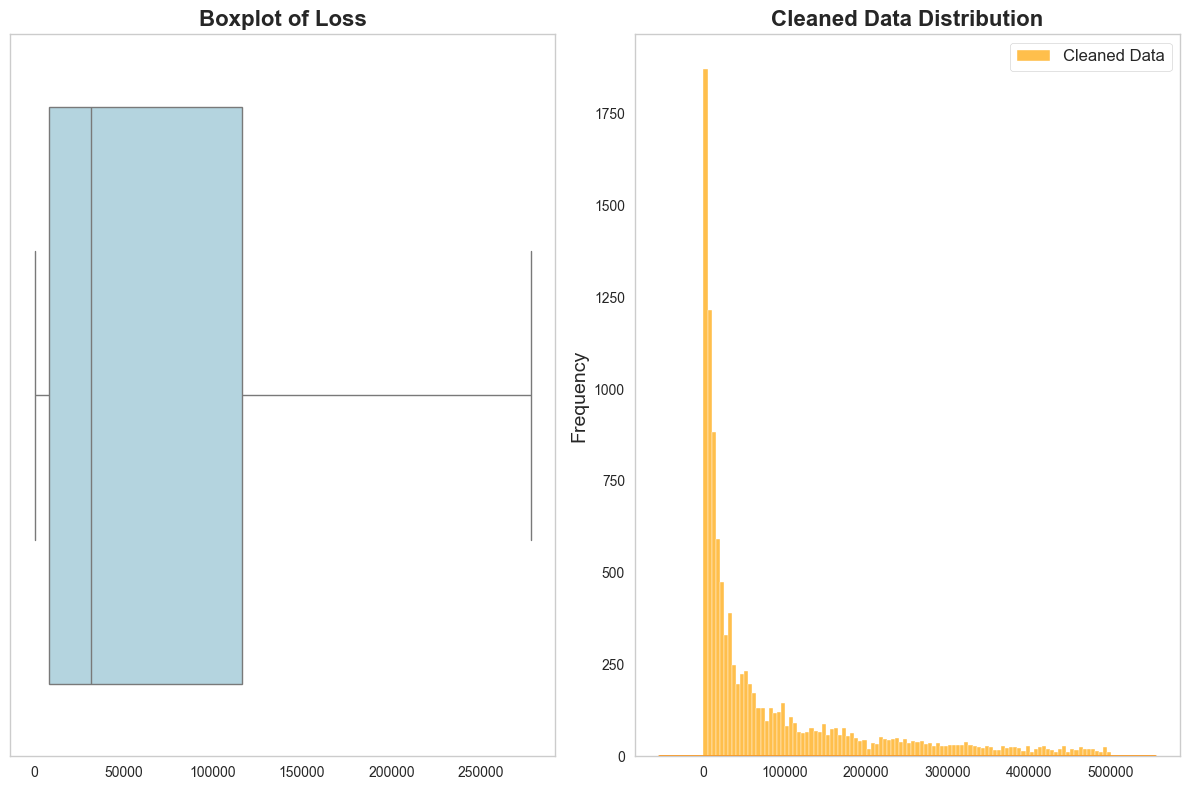

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt

# 设置全局样式
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# 创建子图布局 (1行2列)
plt.subplot(1, 2, 1)
# 绘制箱线图
sns.boxplot(x=df_cleaned['core_loss'], orient='h', showfliers=False, color='lightblue')
plt.title('Boxplot of Loss', fontsize=16, fontweight='bold')
plt.xlabel(None)
plt.ylabel(None)
plt.grid(False)

# 在右边绘制直方图和KDE
plt.subplot(1, 2, 2)
# 绘制直方图和KDE

sns.histplot(df_cleaned['core_loss'], bins=100, alpha=0.7, label='Cleaned Data', color='orange')
sns.kdeplot(df_cleaned['core_loss'], color='darkorange', linewidth=2)

plt.title('Cleaned Data Distribution', fontsize=16, fontweight='bold')
plt.xlabel(None)
# plt.xlabel('Magnetic Core Loss', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(fontsize=12)
# plt.grid(True, linestyle='--', alpha=0.5)
plt.grid(False)
# 调整布局，使子图不重叠
plt.tight_layout()

# 显示图像
plt.show()

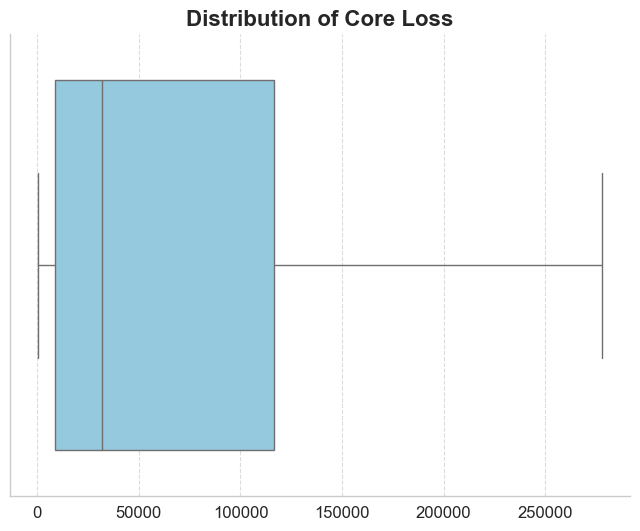

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt

# 设置风格和调色板
sns.set_style("whitegrid")  # 你可以使用 'white', 'darkgrid' 等其他样式
sns.set_palette("muted")    # 选择合适的调色板，例如 "muted", "bright", "pastel" 等

# 创建箱线图
plt.figure(figsize=(8, 6))  # 调整图的大小
sns.boxplot(x=df_cleaned['core_loss'], orient='h', showfliers=False, color="skyblue")  # 使用水平箱线图 (h)

# 去除 x 轴标签，并添加标题
plt.xlabel(None)
plt.title('Distribution of Core Loss', fontsize=16, fontweight='bold')  # 添加标题

# 优化刻度样式
plt.tick_params(axis='both', which='major', labelsize=12)  # 调整刻度文字大小
plt.grid(True, axis='x', linestyle='--', alpha=0.7)  # 仅为x轴添加虚线网格

# 去除右边和上边框
sns.despine(left=False, bottom=False)

# 显示图像
plt.show()

In [5]:
df = pd.read_csv('feature25_with_loss_new.csv')
y = df.iloc[:, -1]
# 计算第一四分位数 (Q1) 和第三四分位数 (Q3)
Q1 = df['core_loss'].quantile(0.25)
Q3 = df['core_loss'].quantile(0.75)
IQR = Q3 - Q1

# 定义异常值的范围
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 去除异常值
df_cleaned = df[(df['core_loss'] >= lower_bound) & (df['core_loss'] <= upper_bound)]

# 打印清理后数据的形状
print(f'清理后数据量: {df_cleaned.shape}')

清理后数据量: (10933, 26)


In [41]:

min(df_cleaned['core_loss']), max(df_cleaned['core_loss'])

(415.6131139, 500840.9623)

In [42]:
df_cleaned[:2]

,mean_flux,std_flux,max_flux,min_flux,range_flux,skewness,symmetric_messure,max_freq,mean_mag,std_mag,...,duty_cicle,rise_time,fall_time,increase_points,decrease_points,material,temperature,frequency,wave_label,core_loss
0,-4.003906e-11,0.020400,0.028849,-0.028840,0.057689,-0.000627,0.036719,48.857422,0.028984,0.652162,...,50.000000,16.0,-75.0,0.0,0.0,0,25,50030,2,1997.95525
1,-2.539063e-11,0.022223,0.031419,-0.031427,0.062846,-0.001222,0.039992,48.847656,0.031583,0.710445,...,50.097656,20.0,-75.0,0.0,0.0,0,25,50020,2,2427.74983


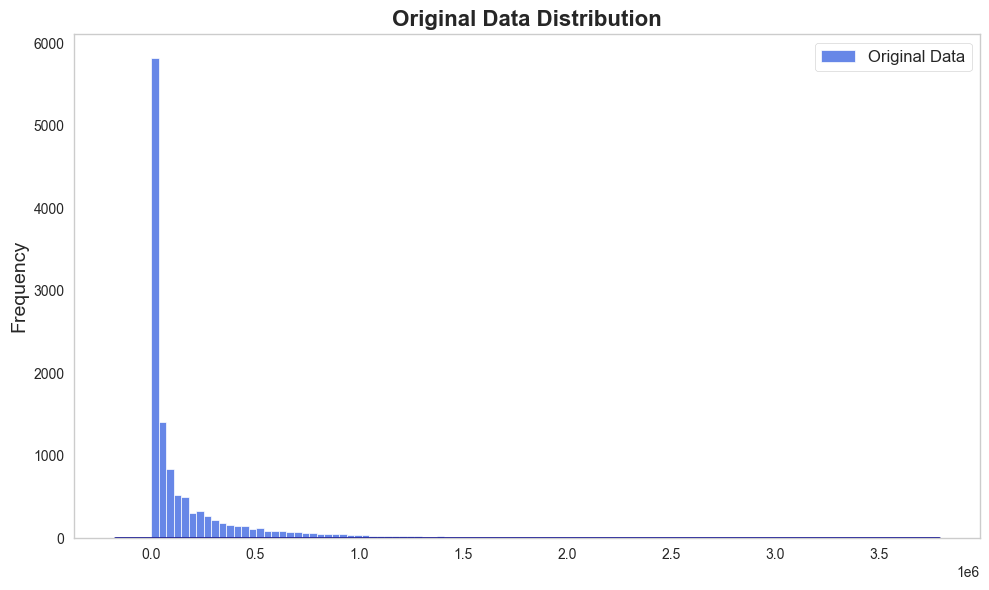

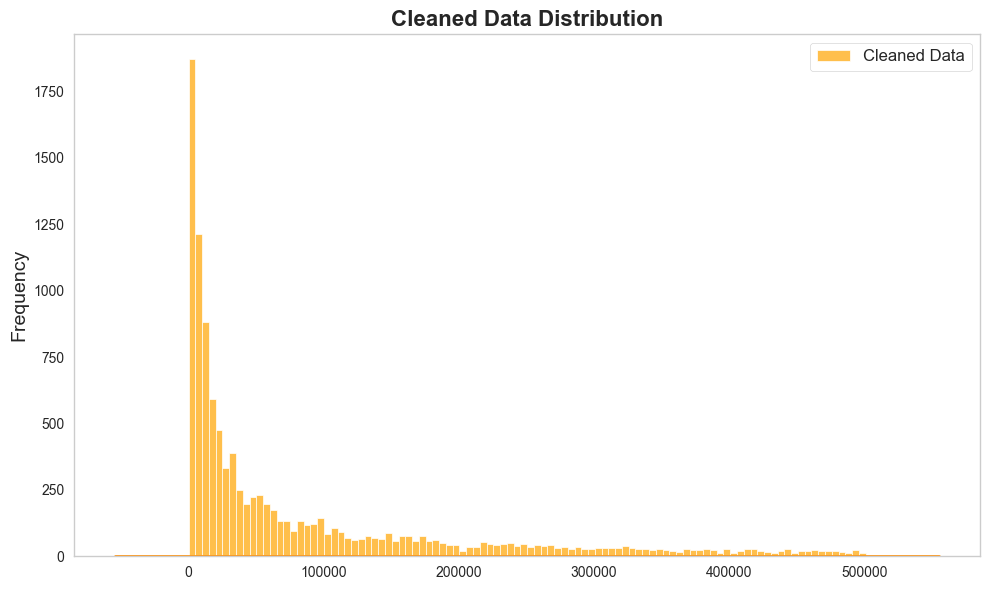

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt

# 设置全局样式
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# 绘制原始数据的直方图
sns.histplot(df['core_loss'], bins=100, alpha=0.8, label='Original Data', color='royalblue')
sns.kdeplot(df['core_loss'], color='darkblue', linewidth=2)

plt.title('Original Data Distribution', fontsize=16, fontweight='bold')
# plt.xlabel('Magnetic Core Loss', fontsize=14)
plt.xlabel(None)
plt.ylabel('Frequency', fontsize=14)
plt.legend(fontsize=12)
# plt.grid(True, linestyle='--', alpha=0.5)
plt.grid(False)
plt.tight_layout()
plt.show()

# 绘制清理后的数据的直方图
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned['core_loss'], bins=100, alpha=0.7, label='Cleaned Data', color='orange')
sns.kdeplot(df_cleaned['core_loss'], color='darkorange', linewidth=2)

plt.title('Cleaned Data Distribution', fontsize=16, fontweight='bold')
plt.xlabel(None)
# plt.xlabel('Magnetic Core Loss', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(fontsize=12)
# plt.grid(True, linestyle='--', alpha=0.5)
plt.grid(False)
plt.tight_layout()
plt.show()

In [44]:
len(df_cleaned['core_loss'])

10933

In [8]:
def custom_loss(output, target):
    # 原始的MSE损失
    mse_loss = torch.mean((output - target) ** 2)
    
    # 对小于300的输出施加惩罚
    penalty_lower = torch.mean((torch.relu(500 - output)) ** 2)
    
    # 对大于600000的输出施加惩罚
    penalty_upper = torch.mean((torch.relu(output - 600000)) ** 2)
    
    # 总损失 = MSE损失 + 惩罚
    return mse_loss + 10 * penalty_lower + 100 * penalty_upper  # 通过调整100的权重来控制惩罚力度

In [35]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load dataset

# Features and target
X = df_cleaned.iloc[:, :-1].values
y = df_cleaned.iloc[:, -1].values

# Data normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)  # Validation set
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)  # Validation set
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define the neural network
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.nn.Softplus()( self.fc4(x)) + 100
        return x


Epoch [1/10000], Training Loss: 20770725888.0000, Validation Loss: 21088675840.0000
Epoch [201/10000], Training Loss: 15754451968.0000, Validation Loss: 16382670848.0000
Epoch [401/10000], Training Loss: 7337198592.0000, Validation Loss: 8263666688.0000
Epoch [601/10000], Training Loss: 5573830144.0000, Validation Loss: 6183731712.0000
Epoch [801/10000], Training Loss: 3955112960.0000, Validation Loss: 4409792000.0000
Epoch [1001/10000], Training Loss: 2909441536.0000, Validation Loss: 3243428864.0000
Epoch [1201/10000], Training Loss: 2180681472.0000, Validation Loss: 2380464640.0000
Epoch [1401/10000], Training Loss: 1482587904.0000, Validation Loss: 1551580672.0000
Epoch [1601/10000], Training Loss: 972552064.0000, Validation Loss: 969101632.0000
Epoch [1801/10000], Training Loss: 722182720.0000, Validation Loss: 697155264.0000
Epoch [2001/10000], Training Loss: 592469120.0000, Validation Loss: 565214656.0000
Epoch [2201/10000], Training Loss: 508208544.0000, Validation Loss: 493665

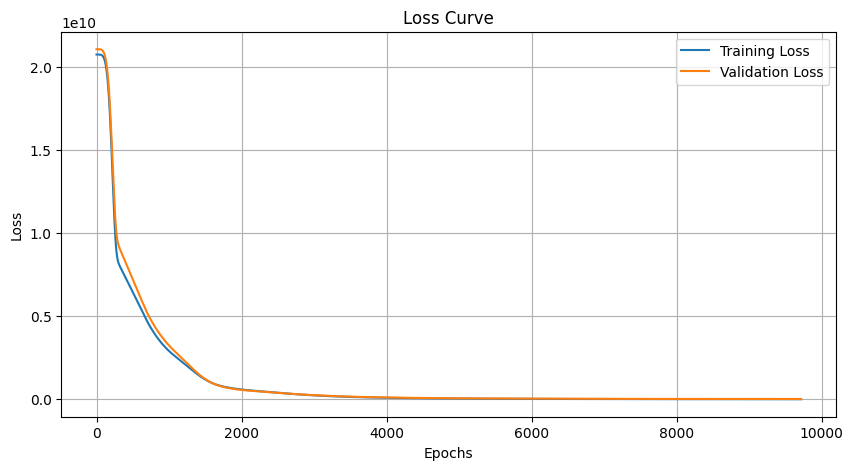

Mean Squared Error (MSE): 22828690.0
R^2 Score: 0.9982890486717224


In [9]:

# Instantiate the model
input_size = X_scaled.shape[1]
model = NeuralNet(input_size)

# Define loss function and optimizer
criterion = custom_loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses = []
val_losses = []
# Early stopping parameters
patience = 50
best_loss = np.inf
patience_counter = 0

# Train the model
num_epochs = 10_000
for epoch in range(num_epochs):
    # Forward pass
    model.train()  # Set to training mode
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Validation phase
    model.eval()  # Set to evaluation mode
    with torch.no_grad():
        val_outputs = model(X_val)  # Use validation set
        val_loss = criterion(val_outputs, y_val)  # Use validation targets
    # Record losses
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    
    # Check for best loss and early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        
        if patience_counter >= patience:
            print('Early stopping triggered!')
            break  # Stop training
    if epoch % 200 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(None)
plt.show()

# Test the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    y_pred = y_pred.numpy()
    y_test = y_test.numpy()

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R^2 Score: {r2}")

In [36]:

model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    y_pred = y_pred.numpy()
    y_test = y_test.numpy()

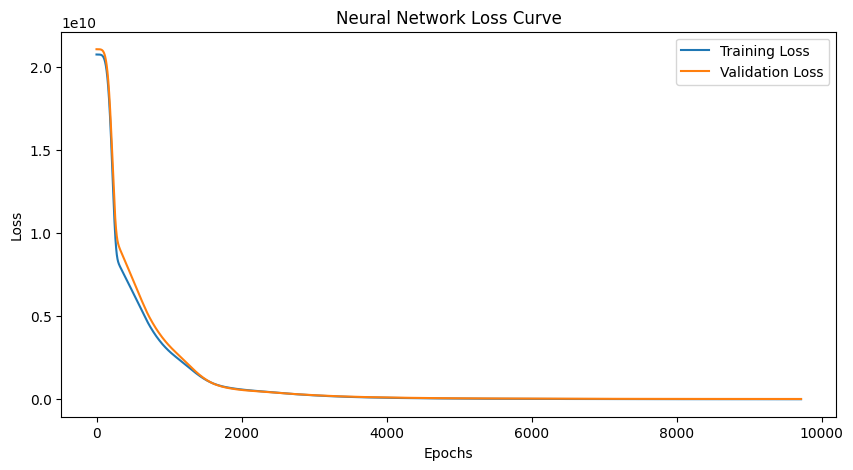

In [34]:

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Neural Network Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(visible=False)
plt.show()

In [90]:
model(X_test)

tensor([[16960.8652],
        [26432.5840],
        [12649.8115],
        ...,
        [ 3542.7969],
        [ 2441.8828],
        [  945.4317]], grad_fn=<AddBackward0>)

In [91]:
y_test, y_pred

(array([[17151.488],
        [18591.85 ],
        [13656.581],
        ...,
        [ 3117.87 ],
        [ 3875.1  ],
        [  840.85 ]], dtype=float32),
 array([[16960.865 ],
        [26432.584 ],
        [12649.812 ],
        ...,
        [ 3542.7969],
        [ 2441.8828],
        [  945.4317]], dtype=float32))

In [96]:
input_size = X.shape[1]
model = NeuralNet(input_size)

# Load the saved weights into the model
model.load_state_dict(torch.load('p4_nn_weights.pth', weights_only=True))

# Set the model to evaluation mode before making predictions
model.eval()

NeuralNet(
  (fc1): Linear(in_features=25, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)

In [100]:
y_pred = model(X_test)
y_pred = y_pred.detach().numpy()
y_pred

array([[16960.865 ],
       [26432.584 ],
       [12649.812 ],
       ...,
       [ 3542.7969],
       [ 2441.8828],
       [  945.4317]], dtype=float32)

In [106]:
p4 = pd.read_csv('p4_problem.csv')
P =  p4.values 
scaler = StandardScaler()
P_scaled = scaler.fit_transform(P)

P_tensor = torch.tensor(P_scaled, dtype=torch.float32)
ret = model(P_tensor)


In [107]:
arr = ret.detach().numpy()
rsp = np.round(arr.flatten().tolist(), 1).tolist()
rsp

[8578.3,
 12953.1,
 19959.7,
 17751.6,
 29830.9,
 9503.3,
 2130.9,
 1786.1,
 233743.7,
 6283.1,
 8744.1,
 70046.8,
 2459.2,
 1921.0,
 13581.3,
 1557.8,
 59793.7,
 142841.1,
 2097.8,
 285714.2,
 869.5,
 17885.3,
 108666.4,
 4478.5,
 10598.1,
 8688.0,
 85754.8,
 183365.8,
 1254.5,
 251285.3,
 3385.2,
 1817.4,
 17843.9,
 28439.2,
 4853.1,
 6157.2,
 24037.9,
 89413.6,
 116385.3,
 335102.9,
 38139.9,
 393884.2,
 286761.4,
 412763.8,
 3961.2,
 25765.2,
 18893.9,
 380000.0,
 6496.7,
 63267.6,
 5003.3,
 52071.1,
 10735.4,
 63810.9,
 20481.2,
 80580.4,
 64343.0,
 122948.8,
 43078.9,
 55384.2,
 107451.4,
 129039.2,
 56144.7,
 130312.5,
 23390.3,
 227378.5,
 23480.3,
 155282.2,
 255092.3,
 184318.4,
 3738.7,
 4442.5,
 242021.5,
 2672.1,
 137008.9,
 733162.9,
 6249.1,
 5137.1,
 7727.1,
 26480.9,
 126069.4,
 120731.8,
 6285.0,
 59071.1,
 31497.6,
 10133.1,
 10149.8,
 698997.2,
 1058621.2,
 6225.9,
 11493.8,
 130604.4,
 22169.2,
 46925.1,
 61878.0,
 789002.8,
 133728.8,
 7076.7,
 42785.3,
 24921.6,


In [108]:
with open('p4_answer.txt', 'w') as f:
    f.write("\n".join([str(i) for i in rsp]))

In [19]:
y_test = y_test.numpy()

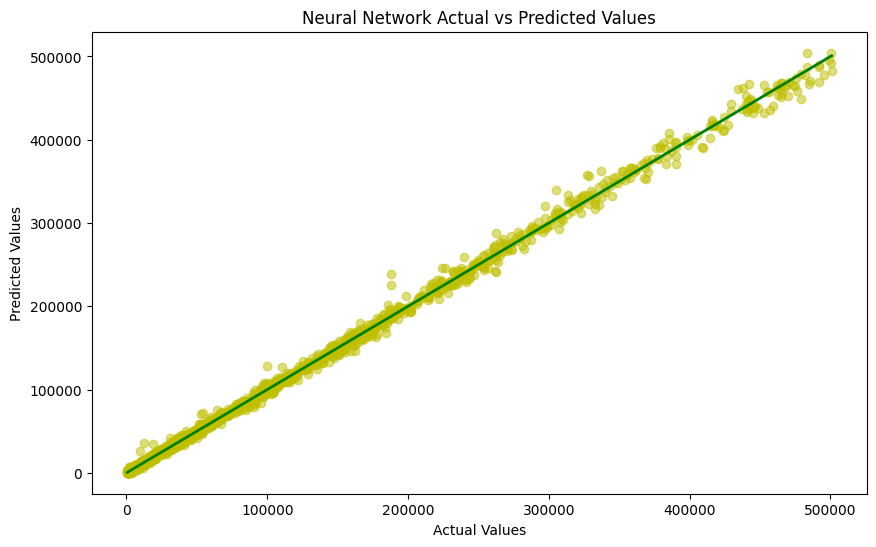

In [38]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, c='y')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'g', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Neural Network Actual vs Predicted Values')
plt.show()

In [73]:
print(y_pred)

[[17143.85  ]
 [18499.273 ]
 [13596.519 ]
 ...
 [ 3082.1465]
 [ 3829.5847]
 [  826.0032]]


In [11]:
data = []
sum = 0
for i in range(-1, 5):
    n = 10 ** i
    a,b = y_pred.flatten() / n, y_test.flatten() / n
    a, b = a.astype(int),b.astype(int)
    s = (a == b)
    data.append(s.sum() / len(y_test) * 100)

In [12]:
data


[np.float64(0.0),
 np.float64(0.0),
 np.float64(0.1371742112482853),
 np.float64(1.4631915866483767),
 np.float64(20.027434842249658),
 np.float64(76.36031092821216)]

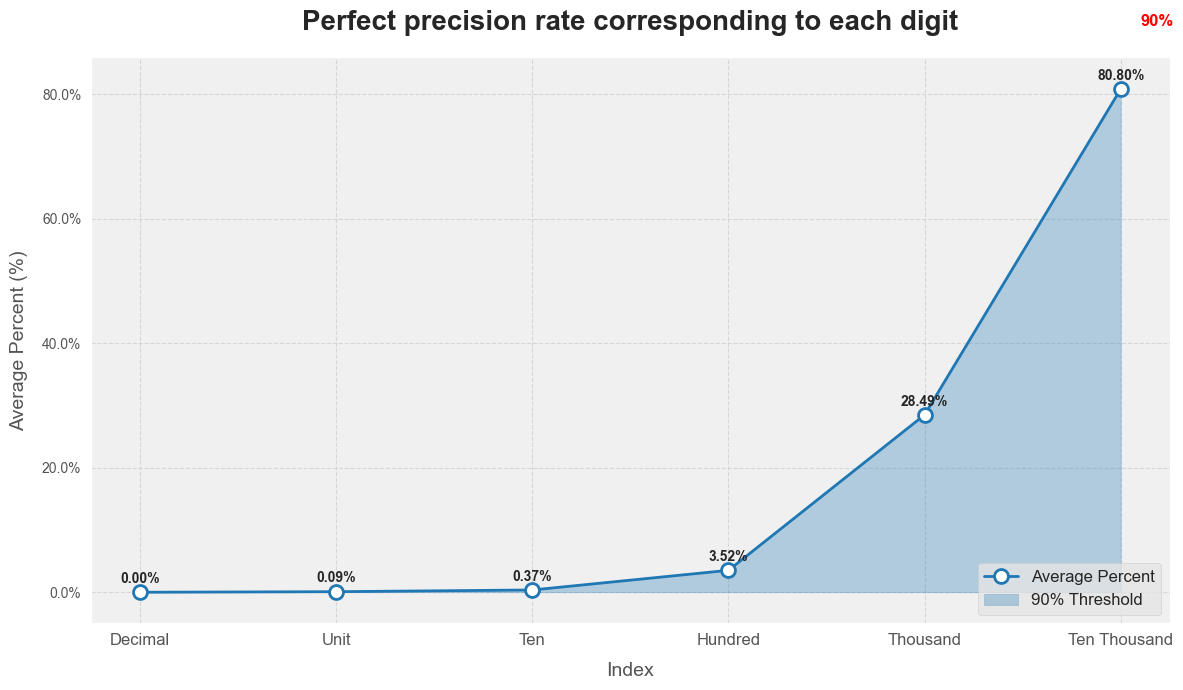

In [94]:
import matplotlib.pyplot as plt
import numpy as np

# 假设你的数据存储在一个列表中，现在我们将其转换为百分比

# 设置颜色主题
main_color = '#1f77b4'  # 深蓝色
background_color = '#f0f0f0'  # 浅灰色背景
grid_color = '#cccccc'  # 浅灰色网格线

# 创建一个新图形
plt.figure(figsize=(12, 7))
plt.style.use('ggplot')  # 使用ggplot样式提高美观度

# 绘制主数据线
plt.plot(range(6), data, marker='o', linestyle='-', linewidth=2, color=main_color, 
         markerfacecolor='white', markeredgecolor=main_color, markeredgewidth=2, markersize=10)

# 添加区域填充
plt.fill_between(range(6), data, alpha=0.3, color=main_color)

# 添加标题和标签
plt.title('Perfect precision rate corresponding to each digit', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Index', fontsize=14, labelpad=10)
plt.ylabel('Average Percent (%)', fontsize=14, labelpad=10)

# 添加网格
plt.grid(True, linestyle='--', alpha=0.7, color=grid_color)

# 设置x轴和y轴范围
custom_xticks = ['Decimal', 'Unit', 'Ten', 'Hundred', 'Thousand', 'Ten Thousand']  # Custom x-axis labels in English
plt.xticks(range(6), custom_xticks, fontsize=12)
y_min, y_max = min(data), max(data)
plt.ylim(y_min - 5, y_max + 5)  # 调整y轴范围，为百分比值留出空间

# 添加90%标注线
plt.axhline(y=90, color='red', linestyle='--', linewidth=2, alpha=0.7)
plt.text(5.1, 91, '90%', color='red', fontsize=12, fontweight='bold')

# 为每个数据点添加标签
for i, val in enumerate(data):
    plt.text(i, val + 1, f'{val:.2f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 设置背景颜色
plt.gca().set_facecolor(background_color)

# 添加图例
plt.legend(['Average Percent', '90% Threshold'], loc='lower right', fontsize=12)

# 移除顶部和右侧边框
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# 设置y轴刻度为百分比格式
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{x:.1f}%"))

# 显示图形
plt.tight_layout()
plt.show()

In [95]:
torch.save(model.state_dict(), 'p4_nn_weights.pth')